<a href="https://colab.research.google.com/github/slarkdev/AnomaliesDetection/blob/main/anomaly_detection_informer_dt2_lesly_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 533.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import os
import datetime
import random
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout

from tensorflow.keras.layers import Input

# Fijar semilla aleatoria
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)



In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [4]:
# !pip install --quiet torch torchvision torchaudio

import torch
import torch.nn as nn
import torch.optim as optim
print("PyTorch version:", torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.6.0+cpu
Using device: cpu


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import sys

informer_path = '/content/drive/MyDrive/informer-lesly/Informer2020'
#if informer_path not in sys.path:
sys.path.append(informer_path)



In [7]:
!ls /content/drive/MyDrive/informer-lesly/Informer2020/models

attn.py  decoder.py  embed.py  encoder.py  __init__.py	model.py  __pycache__


In [8]:
import os
print(os.listdir('/content/drive/MyDrive/informer-lesly/Informer2020/models'))


['__init__.py', 'attn.py', 'decoder.py', 'embed.py', 'encoder.py', '__pycache__', 'model.py']


In [9]:
import importlib.util
spec = importlib.util.find_spec("models.model")
print("Found!" if spec else "Not found.")


Found!


In [11]:
from models.model import Informer

In [12]:
def create_sequences(data, sequence_length):
 X = []
 y = []
 for i in range(len(data) - sequence_length):
    X.append(data.iloc[i:i+sequence_length][input_columns].values)
    y.append(data.iloc[i+sequence_length][output_columns].values)
 return np.array(X), np.array(y)

In [13]:
def guardar_proyecto(core_informer, y_test, anomalías, matriz, epoch_actual, nombre_base="modelo_anomalias"):

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta = f"/content/drive/MyDrive/3w-dataset-train-test/entrenamientos-2/{nombre_base}_{timestamp}"
    os.makedirs(carpeta, exist_ok=True)

    # 1. Guardar el modelo
    checkpoint = {
        'epoch': epoch_actual,
        'model_state': core_informer.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }
    torch.save(checkpoint, 'informer.pth')

    # 2. Guardar métricas
    reporte = classification_report(y_test, anomalías)
    acc = accuracy_score(y_test, anomalías)
    f1 = f1_score(y_test, anomalías)
    recall = recall_score(y_test, anomalías)
    precision = precision_score(y_test,anomalías)
    auc = roc_auc_score(y_test, anomalías)

    with open(os.path.join(carpeta, "reporte_metricas.txt"), "w") as f:
        f.write("REPORTE DE CLASIFICACIÓN\n")
        f.write(reporte)
        f.write("\n\nMétricas adicionales:\n")
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"AUC-ROC: {auc:.4f}\n")


    total_anomalias = int(np.sum(y_test))  # Cantidad total de anomalías
    anomalías_predichas = int(np.sum(anomalías.astype(int)))

    # Crear gráfico de barras
    plt.bar(["Real Anomalies", "Anomalies Detected"], [total_anomalias, anomalías_predichas], color=['red', 'blue'])

    # Personalizar gráfico
    plt.ylabel("Number of Anomalies")
    plt.title("Comparison of Real vs. Predicted Anomalies")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(carpeta, "grafico_comparison_real_vs_anomalies.png"))
    plt.close()

    # grafico 4 matriz de confusion
    sns.heatmap(matriz, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Normal", "Anomalous"], yticklabels=["Normal", "Anomalous"])
    plt.xlabel("Prediction")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(carpeta, "grafico_confusion_matriz.png"))
    plt.close()


    print(f"Todo guardado exitosamente en la carpeta: {carpeta}")


In [14]:
class WindowDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, seq_len=96, label_len=48, pred_len=24):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_enc = self.X[idx][:self.seq_len]
        x_dec = np.concatenate([
            self.X[idx][self.seq_len - self.label_len:self.seq_len],
            np.zeros((self.pred_len, self.X.shape[2]))
        ], axis=0)

        x_mark_enc = np.zeros((self.seq_len, 4))
        x_mark_dec = np.zeros((self.label_len + self.pred_len, 4))

        return (
            torch.tensor(x_enc, dtype=torch.float32),
            torch.tensor(x_mark_enc, dtype=torch.float32),
            torch.tensor(x_dec, dtype=torch.float32),
            torch.tensor(x_mark_dec, dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.float32)
        )

In [15]:
class InformerBin(torch.nn.Module):
    def __init__(self, core):
        super().__init__()
        self.core = core

    def forward(self, x, return_latent=False):
        if x.dim() != 3:
            raise ValueError(f"Expected input of shape (B, L, F), but got {x.shape}")

        B, L, F = x.shape

        x_mark_enc = torch.zeros(B, L, 4, device=x.device)
        x_dec      = torch.zeros(B, 1, F, device=x.device)
        x_mark_dec = torch.zeros(B, 1, 4, device=x.device)

        out = self.core(
            x, x_mark_enc, x_dec, x_mark_dec,
            return_latent=return_latent
        )

        if return_latent:
            return out[:, -1, :]
        else:
            return out[:, 0, 0]

In [16]:
# Especificar las rutas de los archivos en Google Drive
ruta_csv1 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-interpolado-Anomalia1.csv"
ruta_csv2 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-interpolado-Anomalia2.csv"
ruta_csv3 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-test-06.csv"

# Leer los CSV en DataFrames
df1 = pd.read_csv(ruta_csv1, parse_dates=['timestamp'], index_col='timestamp')
df2 = pd.read_csv(ruta_csv2, parse_dates=['timestamp'], index_col='timestamp')
df3 = pd.read_csv(ruta_csv3, parse_dates=['timestamp'], index_col='timestamp')

df1

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2014-01-26 03:33:21,0.995385,0.04225,0.989734,0.015978,1.000000,0.0
2014-01-26 03:33:22,0.995385,0.04225,0.989734,0.015978,1.000000,0.0
2014-01-26 03:33:23,0.995385,0.04225,0.989734,0.015978,1.000000,0.0
2014-01-26 03:33:24,0.995385,0.04225,0.989734,0.015978,1.000000,0.0
2014-01-26 03:33:25,0.995385,0.04225,0.989734,0.015977,1.000000,0.0
...,...,...,...,...,...,...
2014-01-26 22:59:56,0.000000,1.00000,0.041357,0.000000,0.000117,1.0
2014-01-26 22:59:57,0.000000,1.00000,0.041345,0.000000,0.000085,1.0
2014-01-26 22:59:58,0.000000,1.00000,0.041333,0.000000,0.000059,1.0


In [17]:
tam_train = 49000

total = len(df2)
idx_train_start = total - tam_train

# Cortes
train = df2.iloc[idx_train_start:]
test = df2.iloc[:idx_train_start]

print(test['class'].value_counts())
test

class
0.0    15635
1.0     5365
Name: count, dtype: int64


,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2013-11-04 01:41:01,1.000000,0.999478,1.000000,0.0,0.265832,0.0
2013-11-04 01:41:02,1.000000,0.999477,1.000000,0.0,0.265833,0.0
2013-11-04 01:41:03,1.000000,0.999476,1.000000,0.0,0.265833,0.0
2013-11-04 01:41:04,1.000000,0.999475,0.999999,0.0,0.265834,0.0
2013-11-04 01:41:05,1.000000,0.999475,0.999999,0.0,0.265835,0.0
...,...,...,...,...,...,...
2013-11-04 07:30:56,0.998766,0.668012,0.967624,1.0,0.591835,0.0
2013-11-04 07:30:57,0.998766,0.668012,0.967624,1.0,0.591835,0.0
2013-11-04 07:30:58,0.998766,0.668012,0.967624,1.0,0.591835,0.0


In [18]:
columns_names = df2.columns.values
columns_names

array(['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'class'],
      dtype=object)

In [19]:
# Definir las columnas de entrada y salida:
input_columns = ['P-TPT',	'T-TPT','P-MON-CKP', 'T-JUS-CKP','P-JUS-CKGL',]
output_columns = ['class']

In [20]:
train = train.sort_values("timestamp")
test = test.sort_values("timestamp")

print(train['class'].value_counts())
print(test['class'].value_counts())

class
0.0    49000
Name: count, dtype: int64
class
0.0    15635
1.0     5365
Name: count, dtype: int64


In [21]:
VentanaTiempo = 400

# Crear secuencias de entrenamiento
X_train, y_train = create_sequences(train, VentanaTiempo)
X_test, y_test = create_sequences(test, VentanaTiempo)

print(X_train.shape)
print(X_test.shape)

(48600, 400, 5)
(20600, 400, 5)


In [22]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [109]:
d_model = 64
seq_len = VentanaTiempo

# Modelo Informer
model = Informer(
    enc_in=5,
    dec_in=5,
    c_out=1,
    seq_len=seq_len,
    label_len=0,
    out_len=1,
    e_layers=2,
    d_layers=1,
    factor=1,
    dropout=0.1,
    d_model = d_model,
    embed='timeF',
    output_attention=False,
    distil=True,
)

if np.sum(y_train == 1) > 0:
    peso = np.sum(y_train == 0) / np.sum(y_train == 1)
    pos_weight = torch.tensor([peso], device=device)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    criterion = torch.nn.BCEWithLogitsLoss()

optimizer  = torch.optim.Adam(model.parameters(), lr=1e-4)
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=64, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=64, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

In [110]:
import torch.nn.init as init
for m in model.projection.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [111]:
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)


In [112]:
train_dataset = WindowDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

test_dataset = WindowDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)


In [113]:
core_informer = InformerBin(model).to(device)


In [114]:
num_epochs = 10

for epoch in range(num_epochs):
    core_informer.train()
    total_loss = 0

    mean_logit_epoch = []
    std_logit_epoch = []

    for x_enc, x_mark_enc, x_dec, x_mark_dec, yb in train_loader:
        xb = x_enc.to(device)
        yb = yb.to(device).float()

        if yb.dim() > 1:
            yb = yb.squeeze(1)

        optimizer.zero_grad()

        logits = core_informer(xb)
        logits = logits.view(-1)

        mean_logit_epoch.append(logits.mean().item())
        std_logit_epoch.append(logits.std().item())

        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f} | "
          f"logits.mean = {np.mean(mean_logit_epoch):.4f} | "
          f"logits.std = {np.mean(std_logit_epoch):.4f}")




Epoch 1: Loss = 0.0079 | logits.mean = -7.3491 | logits.std = 0.4796
Epoch 2: Loss = 0.0001 | logits.mean = -9.0583 | logits.std = 0.4402
Epoch 3: Loss = 0.0001 | logits.mean = -9.6172 | logits.std = 0.3977
Epoch 4: Loss = 0.0001 | logits.mean = -9.9388 | logits.std = 0.3604
Epoch 5: Loss = 0.0000 | logits.mean = -10.1817 | logits.std = 0.3334
Epoch 6: Loss = 0.0000 | logits.mean = -10.3989 | logits.std = 0.3077
Epoch 7: Loss = 0.0000 | logits.mean = -10.6159 | logits.std = 0.2869
Epoch 8: Loss = 0.0000 | logits.mean = -10.8439 | logits.std = 0.2705
Epoch 9: Loss = 0.0000 | logits.mean = -11.0897 | logits.std = 0.2597
Epoch 10: Loss = 0.0000 | logits.mean = -11.3612 | logits.std = 0.2513


In [115]:
model.eval()
activaciones_train = []

with torch.no_grad():
    for x_enc, x_mark_enc, x_dec, x_mark_dec, yb in train_loader:
        xb = x_enc.to(device)

        #xb = xb.to(device)
        latentes = core_informer(xb, return_latent=True)
        activaciones_train.append(latentes.cpu())

activaciones_train = torch.cat(activaciones_train, dim=0)
centroide = activaciones_train.mean(dim=0)

In [116]:
activaciones_train = []

with torch.no_grad():
    for x_enc, x_mark_enc, x_dec, x_mark_dec, _ in train_loader:
        xb = x_enc.to(device)
        latente = core_informer(xb, return_latent=True)
        activaciones_train.append(latente.cpu())  # suponiendo que ya devuelve shape (B, D)

activaciones_train = torch.cat(activaciones_train, dim=0)

In [117]:
centroide = activaciones_train.mean(dim=0)


In [118]:
distancias = []

with torch.no_grad():
    for x_enc, x_mark_enc, x_dec, x_mark_dec, _ in test_loader:
        xb = x_enc.to(device)
        latente = core_informer(xb, return_latent=True)
        dist = torch.norm(latente.cpu() - centroide, dim=1)  # Euclidiana
        distancias.append(dist)

distancias = torch.cat(distancias, dim=0)

In [119]:
import numpy as np

umbral = np.percentile(distancias.numpy(), 80)
y_pred = (distancias.numpy() > umbral).astype(int)

Accuracy : 0.901504854368932
Precision: 0.9048543689320389
Recall   : 0.6948741845293569
F1-score : 0.7860832894043226
AUC-ROC  : 0.8345719790385544
[[14843   392]
 [ 1637  3728]]
              precision    recall  f1-score   support

         0.0     0.9007    0.9743    0.9360     15235
         1.0     0.9049    0.6949    0.7861      5365

    accuracy                         0.9015     20600
   macro avg     0.9028    0.8346    0.8611     20600
weighted avg     0.9018    0.9015    0.8970     20600



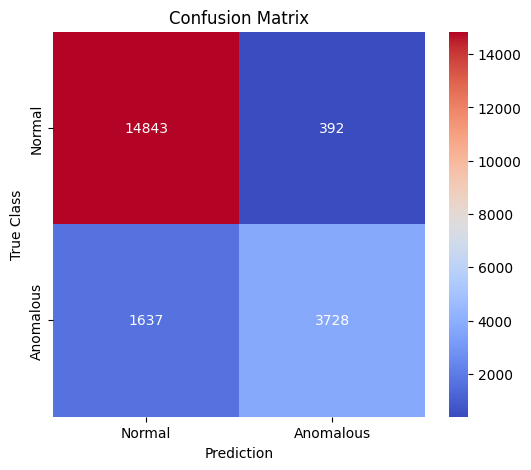

In [120]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred, pos_label=1, average='binary'))
print("AUC-ROC  :", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Normal", "Anomalous"], yticklabels=["Normal", "Anomalous"])
plt.xlabel("Prediction")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

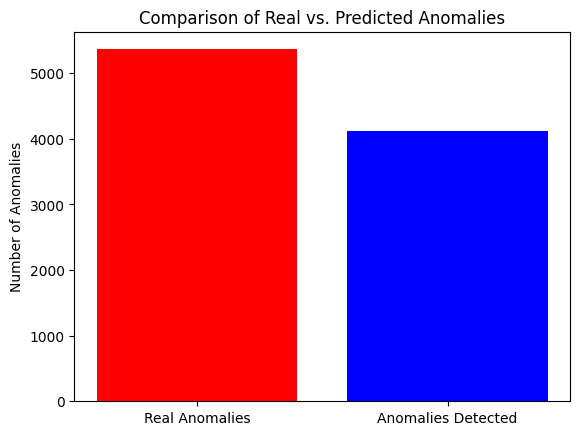

In [121]:
total_anomalias = int(np.sum(y_test))  # Cantidad total de anomalías
anomalías_predichas = int(np.sum(y_pred.astype(int)))  # Convertir booleanos a enteros

# Crear gráfico de barras
plt.bar(["Real Anomalies", "Anomalies Detected"], [total_anomalias, anomalías_predichas], color=['red', 'blue'])

plt.ylabel("Number of Anomalies")
plt.title("Comparison of Real vs. Predicted Anomalies")
plt.show()


In [94]:
guardar_proyecto(core_informer, y_test, y_pred, cm, num_epochs, nombre_base='informer_ocl_dt2_ws_400_bs_64_e_10_acc_9091')

/tmp/ipython-input-13-4109425625.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


✅ Todo guardado exitosamente en la carpeta: /content/drive/MyDrive/3w-dataset-train-test/entrenamientos-2/informer_ocl_dt2_ws_400_bs_64_e_10_acc_9091_20250623_020238


In [ ]:
# usar esta linea solo para guardar tu ultima version de informer modificada

#rutaInformer = '/content/Informer2020'
#!mkdir -p /content/drive/MyDrive/informer-lesly/
#!cp -r /content/Informer2020 /content/drive/MyDrive/informer-lesly/